<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">Gene Expression Analysis</p>
</div>

**Importing Libraries**

In [25]:
#install.packages("BiocManager")
#library("BiocManager")
#library("DESeq2")
#library('tximport')
#library(tidyverse)
#library(ggplot2)
#library(plotly)
#library(biomaRt)
#library(pheatmap)
#library(RColorBrewer)
#library('tibble')
#library(dplyr)

**Loading The Datasets**

In [2]:
# get countnMatrix dataset
count_matrix = as.matrix(read.csv("count.csv", row.names = "Genes"))
# get meta dataset(sample information:studyDesign)
metaData = as.matrix(read.csv("meta.csv", row.names = "Sample"))

#head(count_matrix) #print the  countnMatrix dataset
#head(norm) #print the normalizedMatrix dataset
#print(metaData) #print the meta datasets

dim(count_matrix)
#dim(norm)

[1] 5669   18

**Importing Datasets into DESeq2**

In [24]:
#all(rownames(metaData) %in% colnames(count_matrix))
#all(rownames(metaData) == colnames(count_matrix))
#all(rownames(metaData) %in% colnames(norm))
#all(rownames(metaData) == colnames(norm))

deseq_dataset = DESeqDataSetFromMatrix(countData = count_matrix, colData = metaData, design = ~ Condition)

#print(deseq_dataset)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [4]:
# set control condition as reference
deseq_dataset$Condition = relevel(deseq_dataset$Condition, ref = "Ctrl")

In [23]:
#DESeq does:
#estimatesSizeFactors
#estimatesDispersion
#nbinoWaldtest
#deseq_dataset = DESeq(deseq_dataset)

Exploratory Data Analysis

In [6]:
deseq_result = results(deseq_dataset, contrast = c("Condition",
                                                 "Ctrl","Trt"))
summary(deseq_result) #overall result statistics from DESeq2


out of 5669 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 759, 13%
LFC < 0 (down)     : 563, 9.9%
outliers [1]       : 0, 0%
low counts [2]     : 220, 3.9%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">:)</p>
<p class="last"> So as per DESeq analysis, here in our dataset, we got 5669 genes with non zero read counts with adjusted p-value < 0.1, LFC > 0 for up-reg and LFC < 0 for down-reg and there are 0 outliers based on cooksCutoff distance threshold and there are nearly 220 low count genes with mean count < 1.</p>
</div>

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">:)</p>
<p class="last"> mean with lowest counts start to filter out genes with low expression in the rows because genes of low expression have very low counts numbers(integer values) statistically much likely to be differentially expressed.</p>
</div>

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">:)</p>
<p class="last">mean counts filter plays a big role to maximize the no of genes that pass the statistical thresholds [up-regulated] if we increase the mean count filter, it will start to filter out genes that are genuinely differentially expressed and that get genes removed from the consideration of S-test which filter out **low counts** rows and left us with few rows out of total rows.</p>
</div>

In [7]:
View(deseq_result)
#View(as.data.frame(result_table)

log2 fold change (MLE): Condition Ctrl vs Trt 
Wald test p-value: Condition Ctrl vs Trt 
DataFrame with 5669 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat      pvalue       padj
         <numeric>      <numeric> <numeric> <numeric>   <numeric>  <numeric>
Gene1      25.8459      -0.239398  0.465205 -0.514607 0.606827578 0.76808240
Gene2      19.4426       1.852733  0.939797  1.971418 0.048676130 0.15939677
Gene3     126.8358      -2.011774  0.561396 -3.583523 0.000338991 0.00746396
Gene4     175.5860      -0.667767  0.557330 -1.198155 0.230856787 0.43094849
Gene5      34.3060       0.152564  0.548114  0.278343 0.780749161 0.88575935
...            ...            ...       ...       ...         ...        ...
Gene5665   2.51082      -0.770647  0.915464 -0.841810 0.399894282 0.60077859
Gene5666   3.49467      -0.164902  0.732327 -0.225175 0.821843234 0.90633956
Gene5667  10.72750      -2.096947  0.568256 -3.690143 0.000224128 0.00577944
Gene5668   4.43024       

**In this results table:**
<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">Each of these columns tells something about the expression of the gene in each given row:</p>
</div>

* **baseMeans:** average normalized counts for the gene across all the samples in the columns(experiment), a gene with baseMEan 0 and less than the threshold is filtered out for all the tests.

* **fold change:** that's the difference between two conditions in our differential gene expression test expressed as a log2 ratio.
for example, if FC is 2 means upregulation is 1 if FC is 4 then the upreg is 2, FC is 8  upreg is 3 and so on.. and same as for -ve FC -2 FC means the upregulation goes down towards the zero.
* **lfcSE:** gives us the idea that how robust the change is so larger the lfcSE is less robust the FC observation is

* **stat:** is the result of the wald test, a test of binomial distribution which uses the mean(basemean) and the dispersion which we estimated when we run the estimate dispersion to see the differences between two conditions and that test-statistics is used to convert into the p-value to see the significant differences. 

The p-values are represented in two ways:

**p-value:** which is the output of raw p-value means is this gene differentially expressed may or may not and 
**padj:** this is a p-value adjusted for multiple hypo-test and this is essential for this kind of analysis because we are applying statistical tests on thousands of or beyond datasets points in one go, so these are the linked hypothesis, therefore, it's very important to we take counts of p-values less than < 0.05 it is sufficient to reject null hypo.
so when we consider which genes are differentially expressed it is the padj columns values that we consider for the analysis.

**Heat-Map**

In [8]:
library(pheatmap)
library(RColorBrewer)

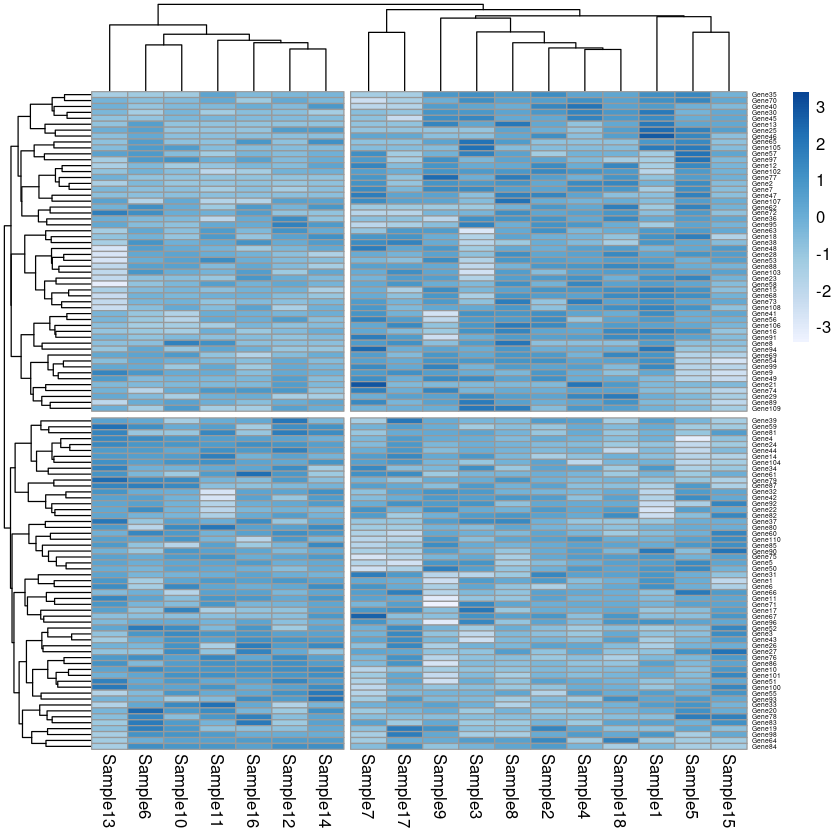

In [9]:
vst = varianceStabilizingTransformation(count_matrix)
data_for_hm = as.matrix.default(vst[1:110, 1:18])

greys = colorRampPalette(brewer.pal(9, "Greys"))(100)
pairs = colorRampPalette(brewer.pal(12, "Paired"))(100)
last_scheme = colorRampPalette(brewer.pal(7, "Blues"))(100)

pheatmap(data_for_hm, fontsize_row=4, scale='row',
         color=last_scheme, cutree_cols = 2,
         cutree_rows = 2)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">So this is a HeatMap of those differentially expressed genes which looks quite nice as you can see the sample on right clearly up-regulated expression is higher than the sample on the left, and block of the bottom down-regulated genes expression level higher in the right and low on the left side.</p>
</div>

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">The way we normally think about heatmap is having columns and rows exactly the same as the matrix.</p>
</div>

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">heatmap colours these cells according to the expressions of that gene in particular samples and heatmap also applied clustering over the top of it, and so we end with a dendrogram linking the samples together as well as genes together which have different clusters of genes.</p>
</div>

**PCA-Plot** 

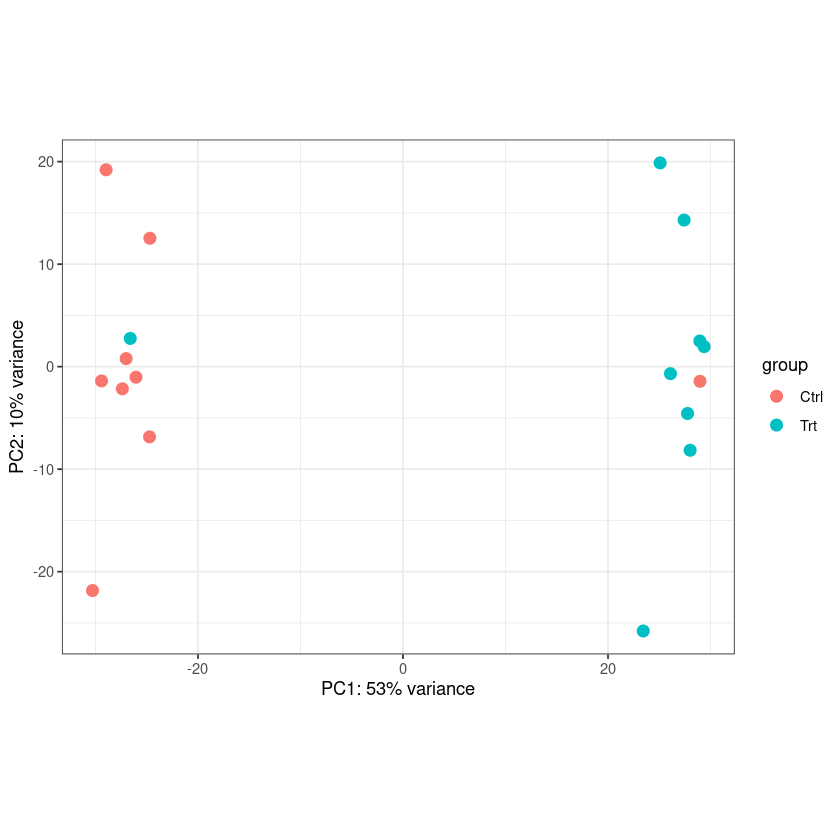

In [10]:
vst = varianceStabilizingTransformation(deseq_dataset)
plotPCA(vst, intgroup=c("Condition"))+
  theme_bw()

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> Before perfoming PCA we need to transform count datasets using   varianceStabilizingTransformation which gives us the right shape for PCA in order to produce a representation of dataset which is meanable for PCA.</p>
</div>

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">The main thing in PCA is to use for bioinformatician is that the closer the two-point is on this plot the most they similar to one another. and this PCA represents the amount of variance in dataest which explains the proportion of the variance in the data. where the PC1 exlains 53% of the variance in the whole dataset. [DESeq2 PCAplot only uses the top 500 most defferentially expressed genes] and PC2 which represents 10% variance and we see on the X-axis, we see that the variance due to drug that in this plot affecting the gene expression  and on the other hand control sample group: a bit more variable than affecting sample group and kind of widespread on the PCA so both of this sample behave differently quite 
nicely. if they most spread on the x-axis or y-axis we can say larger anmout of variations.</p>
</div>


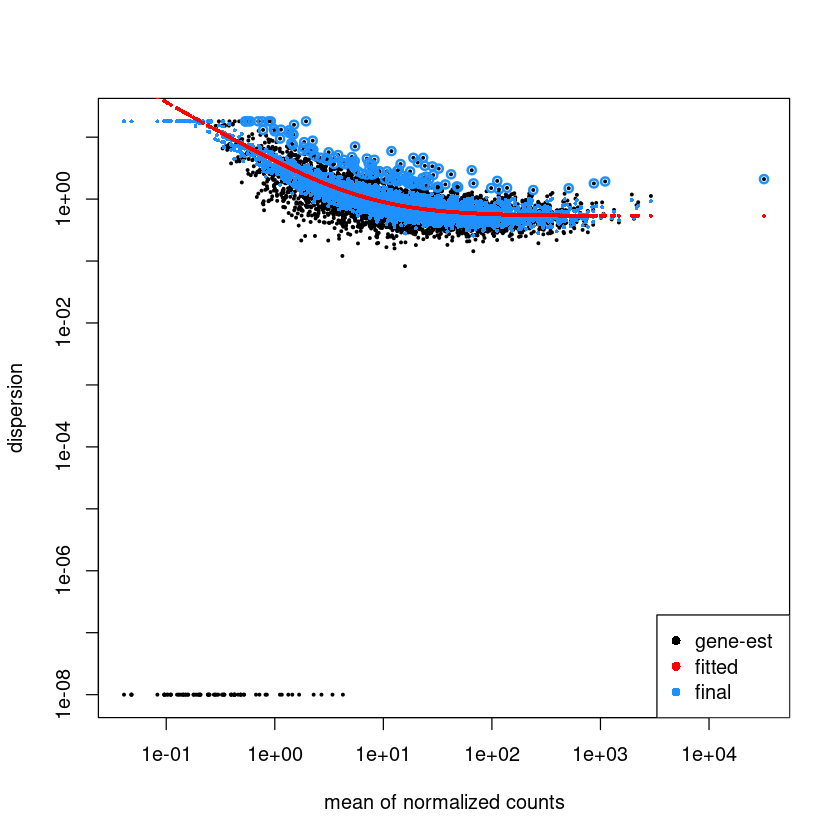

In [11]:
plot1 = plotDispEsts(deseq_dataset)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> This calculates the gene-wise dispersion estimates for the datasets and applies the shrinkage and gives us final dispersion estimates.</p>
</div>
<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> Normal relationship on RNASeq data: So here mean and variance in RNAseq data are not independent of one another so the variance is not continuous with mean of count data, as mean count from left to right increases and variance goes down.</p>
</div>
<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> Worth noting here is, that the black point is the gene-wise estimates of dispersion so that fresh genes from the total observation dispersion have been estimated.</p>
</div>

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> So mean dispersion with the mean and average dispersion with average counts fitted through the red line and black point shrunk towards the red fitted line [dispersion estimates] so the resulting dispersion estimates gene-wise are than the blue points.</p>
</div>
<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> There are two groups of blue points, one is scattered around the red line and the second scattered around the black point away and from the fitted first blue points, these are actually genes which are considered as outliers in terms of dispersion.</p>
</div>

#### Retrive and filter results
**Criteria to filter datasets:**
* padj < 0.05
* log2FoldChange > 1 < -1


In [12]:
result_df = as.data.frame(deseq_result) #DESeq dataframe to R-base Dataframe
head(result_df) # result_table is a DataFrame not a data.frame: a base-r dataframe

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gene1,25.84594,-0.2393976,0.4652047,-0.5146071,0.6068275784,0.768082399
Gene2,19.44258,1.8527331,0.9397974,1.9714176,0.0486761297,0.159396773
Gene3,126.83579,-2.0117739,0.5613956,-3.5835231,0.0003389907,0.007463961
Gene4,175.58604,-0.6677671,0.5573296,-1.1981547,0.2308567869,0.430948486
Gene5,34.30602,0.1525636,0.5481139,0.2783429,0.7807491609,0.885759354
Gene6,15.82625,-0.7964497,0.6016753,-1.3237203,0.1855959644,0.377114418


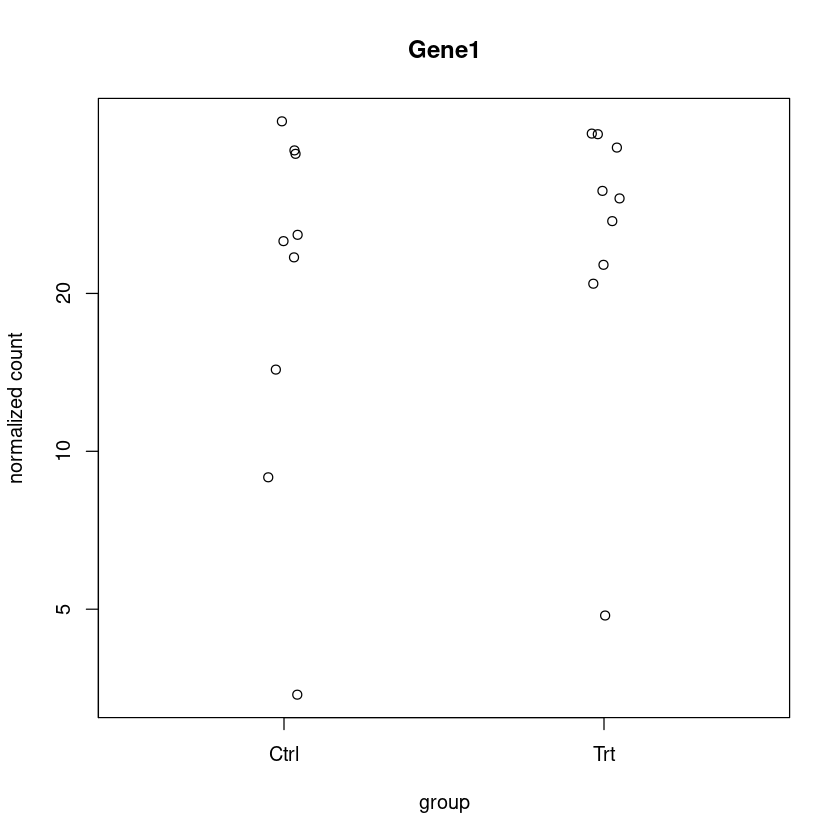

In [13]:
plotCounts(deseq_dataset, gene='Gene1',
           intgroup='Condition')

As per plotCounts graph Ctrl and Trt having higher outlier can be filtered out by applying cooksCutoff distance.

**Three steps to DESeq2 analysis:** which will give us all of the genes which pass all the filters.
* estimate size factors (normalisation)
* estimate dispersions
* apply statistics (Wald Test)


In [14]:
#complete.cases(result_df)
#sum(complete.cases(result_df))
filter_df1 = result_df[complete.cases(result_df),]
#View(filter_df1) 
dim(filter_df1)

[1] 5449    6

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> So here in our datasets out of [5669/. from result statistics DESeq2] nearly 5449 data points are true which pass the all the DESeq2 filtters.</p>
</div>

* True: for represent the observation 
* False: represent the NA

In [15]:
#filter_df1$padj < 0.05
filter_df2 = filter_df1[filter_df1$padj < 0.05,]
#View(filter_df2)
dim(filter_df1)

[1] 5449    6

* if the p-vlues condition meet all values will be TURE
* if not all values will be FASLE
* **Calculation** by looking at result table from DESeq2:
5669 - 220 - 0 = 5449

In [16]:
#abs(filter_df2$log2FoldChange) > 1
filter_df3 = filter_df2[abs(filter_df2$log2FoldChange) > 0.25,]  #filter with abs value 
#View(filter_df3)
dim(filter_df3)

[1] 834   6

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Final Result:</p>
<p class="last">So in total 834 genes which pass all of the filter criteria </p>
</div>


**MA-Plot**

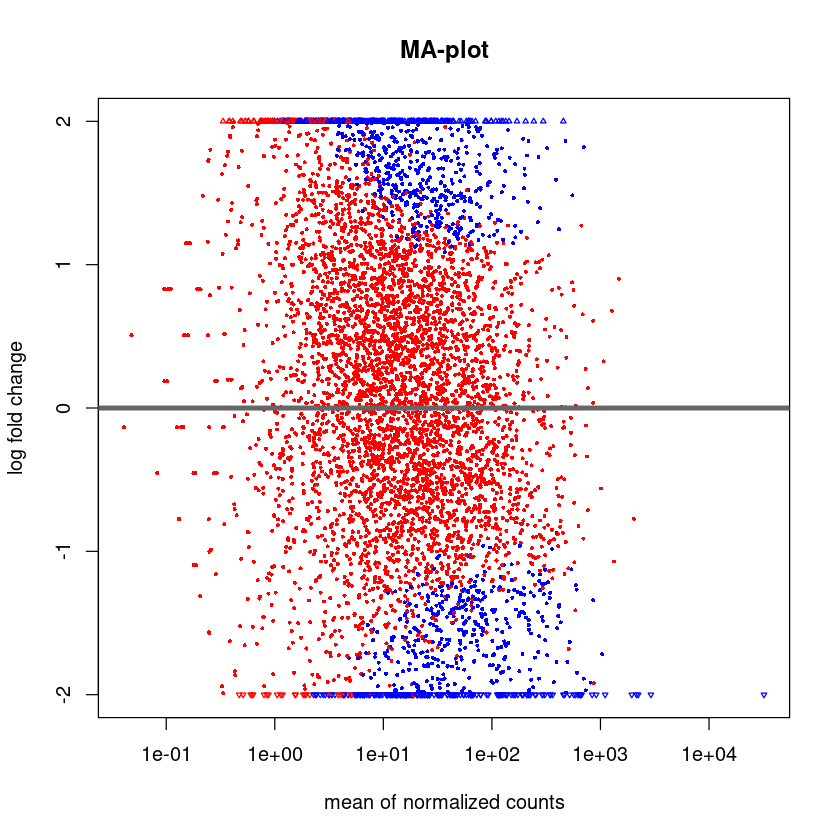

In [17]:
plotMA(deseq_result, ylim=c(-2,2), main = "MA-plot", colNonSig = "red")

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> MA-plot aims to represent the comparison of mean(x-axis) normalized counts[baseMean] and FoldChange (y-axis) from the result table which illustrate a few things.</p>
</div>
<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> The high level of variance presence of low count genes with low counts tend to have quite high fold changes but they don't tend to be significantly differentially expressed. Anything colour in red is just an adjusted p-value lower than 0.01 which is not been used to define DE-genes.</p>
</div>
<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> So here those genes with low expression tend to have to be more spread away from the Zero line [log-fold change] they tend to be significant, and genes with low counts don't tend to be robustly differently expressed and higher mean counts tend to be more likely to DE-genes.</p>
</div>


**volcano plot**

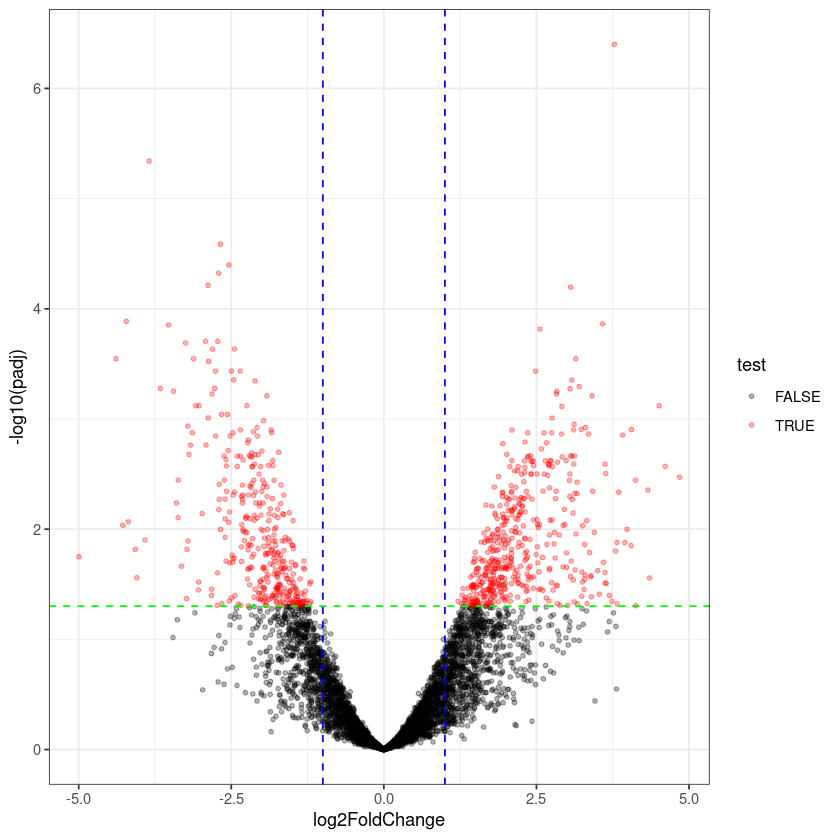

In [18]:
filter_df1$test = filter_df1$padj < 0.05 & abs(filter_df1$log2FoldChange) > 1 #combine test
ggplot(filter_df1, aes(x=log2FoldChange, y = -log10(padj))) +
geom_point(aes(colour = test ), size=1, alpha=0.3 )+
scale_colour_manual(values=c('black', 'red')) +
geom_vline(xintercept = 1, colour="blue", linetype=2) +
geom_vline(xintercept = -1, colour="blue", linetype=2) +
geom_hline(yintercept = -log10(0.05),colour="green",  linetype=2) +
#theme(legend.position = "none")
#xlim(-3,3)+
#ylim(0,10)+
#ggplotly(g)
theme_bw()

**Genes annotated Volcano Plot**

In [19]:
#filter_df1$test = filter_df1$padj < 0.05 & abs(filter_df1$log2FoldChange) > 1 #combine test
#filter_df1 = rownames_to_column(filter_df1, var = 'ensgene')
#g = ggplot(filter_df1, aes(x=log2FoldChange, y = -log10(padj),name = ensgene')) +
#geom_point(aes(colour = test ), size=1, alpha=0.3)+
#scale_colour_manual(values=c('black', 'red'))+
#geom_vline(xintercept = 1, colour="green", linetype=3)+
#geom_vline(xintercept = -1, colour="green", linetype=2)+
#geom_hline(yintercept = -log10(0.05),colour="blue",  linetype=2)+
#theme(legend.position = "none")
#xlim(-3,3)+
#ylim(0,10)+
#theme_bw()
#ggplotly(g)



<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Somehow it is similar to the MA plot:</p>
<p class="last"> On the log2-fold change on the x-axis, so the idea is how many genes change on the axis, so here we can see Up and Down-regulated genes.</p>
</div>

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last"> On the y-axis idea is how significant that change is, it represents the adjusted p-value but in order that more significant genes come up higher on the y-axis, so here we log transform it, so actually the way normally represented is like the -log10 of the p-value and the reason for that is because p-values lie between 0 and 1. so here more significant p-value is when smaller the p-value is than higher the -log10 p-value is.</p>
</div>
<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">Point with a low fold change tend to also have a small p-value.</p>
</div>
<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">Fold change increases at the same time p-value also tend to increases</p>
</div>



**Annotation with biomaRt**

In [20]:
#install.packages('biomaRt')
#library('biomaRt')
#??biomaRt
#??DESeq2
#listMarts()

#ensembl106 = useEnsembl(biomart ="ensembl", version = 106) #datasets
#View(listDatasets(ensembl106))

#ensembl106 = useDataset("hsapiens_gene_ensembl", mart = ensembl106 ) #dataselection
#View(listAttributes(ensembl106))
#View(listFilters(ensembl106))

#getBM(attributes = c("ensembl_gene_id",
                     #"ensembl_gene_id_version",
                     #"ensembl_transcript_id",
                    #"ensembl_transcript_id_version",
                    #"external_gene_name"), filters = c('ensembl_gene_id'), 
      #values = filter_df1,
      #mart = ensembl106)

#annotation = getBM(attributes=('ensembl_gene_id'), #combine annotation with RNASeq dataset
                   #filters = ('ensembl_gene_id'),
                   #values = filter_df1$ensgene,
                   #mart = ensembl106)
#View(annotation)
#View(filter_df1)

#annotated_df = left_join(filter_df1, annotation,
                         #by=c('ensgene'='ensembl_gene_id'))
#View(annotated_df)

In [21]:
write.csv(as.data.frame(filter_df3), file="condition_ctrl_vs_trt_dge.csv") #save the final result.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Gene ranking</p>
<p class="last">These are the top 10 genes listed above sorted by logFC > 1 for highest_top and logFC < 1 lowest_top.</p>
</div>

In [22]:


highest_top = c("Gene7","Gene13","Gene30","Gene35","Gene45","Gene46","Gene47","Gene54","Gene57","Gene73")
lowest_top = c("Gene3","Gene24","Gene26","Gene43","Gene51","Gene80","Gene81","Gene86","Gene93","Gene100")

top_genes = data.frame(highest_top, lowest_top)
top_genes

highest_top,lowest_top
<chr>,<chr>
Gene7,Gene3
Gene13,Gene24
Gene30,Gene26
Gene35,Gene43
Gene45,Gene51
Gene46,Gene80
Gene47,Gene81
Gene54,Gene86
Gene57,Gene93


<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;"></p>
<p class="last">----------------------------------------------------------------------------------------------</p>
</div>


#### References

[Reference1](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) | 
[Reference2](https://rpkgs.datanovia.com/ggpubr/reference/ggmaplot.html) |
[Reference3](https://sbc.shef.ac.uk/workshops/2019-01-14-rna-seq-r/rna-seq-annotation-visualisation.nb.html)

### Thank you, 

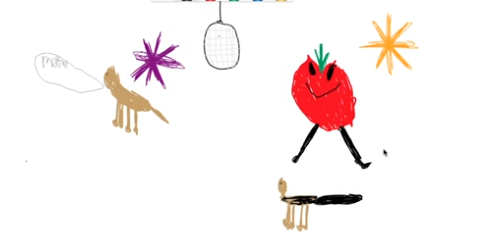